# Libraries 

In [16]:
import os
import random
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import glob
import Bio

from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.internal_coords import *
from Bio.PDB import NeighborSearch

import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D

import protein_parser

## Reading PDB files and protein info

In [17]:
parser=PDBParser(PERMISSIVE=1)

structure_id='test_protein'
#filename='/Users/alexchilton/Downloads/archive/train/AF-A0A0H2UPE1-F1-model_v4.pdb'
filename='/Users/alexchilton/Downloads/archive/train/AF-D0ZA02-F1-model_v4.pdb'

structure=parser.get_structure(structure_id, filename)

In [18]:
aa_info=pd.read_csv('aa_mass_letter.csv')
aa_info_dict = aa_info.set_index('Abbrev.').to_dict(orient='index')

## Select one example protein

In [19]:
# to get the whole dict with the header in one shot
from Bio.PDB import parse_pdb_header
with open(filename, "r") as handle:
    header_dict = parse_pdb_header(handle)

In [20]:
header_dict

{'name': 'alphafold monomer v2.0 prediction for antimicrobial peptide gp-19 (b3a0l2)',
 'head': '01-jun-22',
 'idcode': '',
 'deposition_date': '2022-06-01',
 'release_date': '1909-01-08',
 'structure_method': 'unknown',
 'resolution': None,
 'structure_reference': ['john jumper, richard evans, alexander pritzel, tim grmichael figurnov, olaf ronneberger, kathryn tunyasuvuruss bates, augustin zidek, anna potapenko, alex bridclemens meyer, simon a a kohl, andrew j ballard, andrew cowie, bernardino romera-paredes, stanislav nirishub jain, jonas adler, trevor back, stig petersen,david reiman, ellen clancy, michal zielinski, martin steinegger, michalina pacholska, tamas berghamdavid silver, oriol vinyals, andrew w senior, koray kavukcuoglu, pushmeet kohli, demis hassabis highly accurate protein structure prediction with alpnature v. 596 583 2021 issn 0028-0836 34265844 10.1038/s41586-021-03819-2 ers d data, copyright (2021) deepmind technologies limiteion provided is theoretical modelling o

## Sequence

In [21]:
# Using C-N
from Bio.PDB.Polypeptide import PPBuilder

ppb = PPBuilder()
for pp in ppb.build_peptides(structure):
    print(pp.get_sequence())

GPVGLLSSPGSLPPVGGAP


# Reconstructing a 3D structure from the PDB file

## C-alpha matrix with aa info

In [24]:
# Initialize list to store data for the C-alpha matrix
c_alpha_matrix = []

# Loop through each residue in the structure
for model in structure:
    for chain in model:
        for residue in chain:
            res_name = residue.get_resname().title()
            # Check if residue name is in aa_info dictionary
            if res_name in aa_info_dict:
                aa_letter = aa_info_dict[res_name]['Short']
                # Check if residue has a C-alpha atom
                if 'CA' in residue:
                    # Get C-alpha coordinates
                    ca_atom = residue['CA']
                    x, y, z = ca_atom.get_coord()
                    
                    # Append to the matrix
                    c_alpha_matrix.append([
                        x, y, z,                         # 3D coordinates
                        aa_letter,                       # Amino acid letter
                        aa_info_dict[res_name]['Avg. mass (Da)']  # Mass info
                    ])
                else:
                    print(f"No C-alpha atom found for residue {res_name} in chain {chain.id}")
            else:
                print(f"Residue {res_name} not in amino acid info dictionary.")

# Convert to DataFrame
c_alpha_df = pd.DataFrame(c_alpha_matrix, columns=["X", "Y", "Z", "AA", "Mass"])

# Show DataFrame or debug message
if c_alpha_df.empty:
    print("C-alpha DataFrame is empty. Check residue names or PDB file.")
else:
    print(c_alpha_df)


         X      Y       Z AA       Mass
0  -12.419 -1.418  15.521  G   75.06714
1  -10.350  0.721  13.091  P  115.13194
2  -12.642  0.206  10.062  V  117.14784
3  -11.276  3.392   8.477  G   75.06714
4   -8.779  3.155   5.539  L  131.17464
5  -11.191  3.019   2.578  L  131.17464
6   -8.647  3.814  -0.164  S  105.09344
7  -10.362  5.774  -2.943  S  105.09344
8   -9.953  3.978  -6.324  P  115.13194
9   -6.637  5.594  -7.454  G   75.06714
10  -5.227  6.664  -4.001  S  105.09344
11  -2.555  3.972  -3.621  L  131.17464
12   0.453  5.384  -1.708  P  115.13194
13   3.592  4.904  -3.885  P  115.13194
14   4.646  1.358  -2.924  V  117.14784
15   8.342  2.205  -3.048  G   75.06714
16  10.566  2.584  -6.088  G   75.06714
17  10.538  2.940  -9.854  A   89.09404
18  12.853  4.784 -10.972  P  115.13194


### c-alpha pairwise distance heatmap

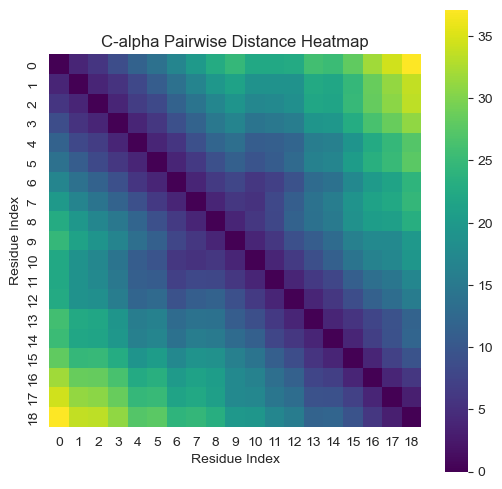

In [25]:
# Check if DataFrame has required data
if c_alpha_df.empty:
    print("C-alpha DataFrame is empty. Please ensure it contains data before plotting.")
else:
    # Extract C-alpha coordinates
    coordinates = c_alpha_df[['X', 'Y', 'Z']].values
    num_residues = len(coordinates)

    # Calculate pairwise distances
    distance_matrix = np.zeros((num_residues, num_residues))
    for i in range(num_residues):
        for j in range(i, num_residues):
            dist = np.linalg.norm(coordinates[i] - coordinates[j])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist  # Symmetric matrix

    # Plotting the heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(distance_matrix, cmap="viridis", square=True)
    plt.title("C-alpha Pairwise Distance Heatmap")
    plt.xlabel("Residue Index")
    plt.ylabel("Residue Index")
    plt.show()


### c-alpha 3d-structure with aa information

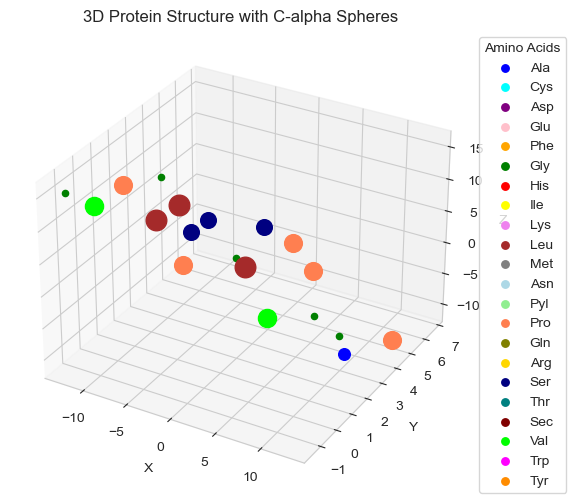

In [26]:
# Define color mapping for amino acids
color_map = {
    'A': 'blue', 'C': 'cyan', 'D': 'purple', 'E': 'pink', 'F': 'orange',
    'G': 'green', 'H': 'red', 'I': 'yellow', 'K': 'violet', 'L': 'brown',
    'M': 'grey', 'N': 'lightblue', 'O': 'lightgreen', 'P': 'coral', 'Q': 'olive',
    'R': 'gold', 'S': 'navy', 'T': 'teal', 'U': 'maroon', 'V': 'lime',
    'W': 'magenta', 'Y': 'darkorange'
}

# Map single-letter amino acid codes to their abbreviations from aa_info_dict
aa_name_map = aa_info.set_index('Short')['Abbrev.'].to_dict()

# Check if DataFrame has required data
if c_alpha_df.empty:
    print("C-alpha DataFrame is empty. Please ensure it contains data before plotting.")
else:
    # Extract coordinates and additional info
    coords = c_alpha_df[['X', 'Y', 'Z']].values
    aa_letters = c_alpha_df['AA']
    masses = c_alpha_df['Mass']
    
    # Normalize masses for sphere sizes, increase scaling for larger spheres
    normalized_sizes = (masses - masses.min()) / (masses.max() - masses.min()) * 200 + 20

    # Plot in 3D
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each C-alpha as a sphere
    for i, (x, y, z, aa, mass) in enumerate(zip(coords[:, 0], coords[:, 1], coords[:, 2], aa_letters, normalized_sizes)):
        ax.scatter(x, y, z, s=mass, c=color_map.get(aa, 'black'))

    # Add a legend with full amino acid names using dummy points
    for aa, color in color_map.items():
        full_name = aa_name_map.get(aa, 'Unknown')
        ax.scatter([], [], [], color=color, label=full_name)  # Dummy points for legend

    # Customize plot appearance
    ax.set_title("3D Protein Structure with C-alpha Spheres")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.legend(title="Amino Acids", loc="upper left", bbox_to_anchor=(1, 1), markerscale=1.2)
    plt.show()


In [31]:
import plotly.graph_objects as go

# Define color mapping for amino acids
color_map = {
    'A': 'blue', 'C': 'cyan', 'D': 'purple', 'E': 'pink', 'F': 'orange',
    'G': 'green', 'H': 'red', 'I': 'yellow', 'K': 'violet', 'L': 'brown',
    'M': 'grey', 'N': 'lightblue', 'O': 'lightgreen', 'P': 'coral', 'Q': 'olive',
    'R': 'gold', 'S': 'navy', 'T': 'teal', 'U': 'maroon', 'V': 'lime',
    'W': 'magenta', 'Y': 'darkorange'
}

# Map single-letter amino acid codes to their abbreviations from aa_info_dict
aa_name_map = aa_info.set_index('Short')['Abbrev.'].to_dict()

# Check if DataFrame has required data
if c_alpha_df.empty:
    print("C-alpha DataFrame is empty. Please ensure it contains data before plotting.")
else:
    # Extract coordinates and additional info
    coords = c_alpha_df[['X', 'Y', 'Z']].values
    aa_letters = c_alpha_df['AA']
    masses = c_alpha_df['Mass']

    # Normalize masses for sphere sizes, increase scaling for larger spheres
    normalized_sizes = (masses - masses.min()) / (masses.max() - masses.min()) * 200 + 20

    # Create a scatter plot for C-alpha atoms
    scatter = go.Scatter3d(
        x=coords[:, 0],
        y=coords[:, 1],
        z=coords[:, 2],
        mode='markers',
        marker=dict(
            size=normalized_sizes,
            color=[color_map.get(aa, 'black') for aa in aa_letters],
            opacity=0.8
        ),
        text=[aa_name_map.get(aa, 'Unknown') for aa in aa_letters],
        hoverinfo='text'
    )

    # Create lines for backbone connections
    backbone_lines = []
    for start, end in backbone_connections:
        backbone_lines.append(go.Scatter3d(
            x=[start[0], end[0]],
            y=[start[1], end[1]],
            z=[start[2], end[2]],
            mode='lines',
            line=dict(color='darkgrey', width=2),
            hoverinfo='none'
        ))

    # Create lines for non-covalent interactions
    interaction_lines = []
    for start, end in non_covalent_interactions:
        interaction_lines.append(go.Scatter3d(
            x=[start[0], end[0]],
            y=[start[1], end[1]],
            z=[start[2], end[2]],
            mode='lines',
            line=dict(color='lightcoral', width=0.5, dash='dash'),
            hoverinfo='none'
        ))

    # Combine all traces
    data = [scatter] + backbone_lines + interaction_lines

    # Create layout
    layout = go.Layout(
        title="3D Protein Structure with Backbone and Interactions",
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        legend=dict(title="Amino Acids & Connections"),
        width=1200,  # Increase the width
        height=900   # Increase the height
    )

    # Create figure
    fig = go.Figure(data=data, layout=layout)

    # Show plot
    fig.show()

## Neighborhood informations

For a more accurate 3d structure we can also look for the neighborhood informations. The neighborhood informations include the carbon backbone, that is basically whoch aminoacid is connected to which aminoacid and the non-covalent interactions, that are interaction between atoms not directly connected among each other but that cause for the atoms to be closer within each other in the 3d space. 

In [27]:
# Initialize lists to store connections
backbone_connections = []
non_covalent_interactions = []

# Non-covalent interactions using NeighborSearch
atom_list = [atom for atom in structure.get_atoms()]
neighbor_search = NeighborSearch(atom_list)

for res in structure.get_residues():
    if 'CA' in res:
        center = res['CA'].get_coord()  # Use C-alpha as central atom for each residue
        neighbors = neighbor_search.search(center, 5.0)  # Find atoms within 5 Å radius

        for neighbor in neighbors:
            if neighbor.get_parent() != res and neighbor.element != 'H':  # Avoid self and hydrogen atoms
                non_covalent_interactions.append((res, neighbor.get_parent()))

# Print or analyze the connections
print("Backbone Connections (Peptide Bonds):")
for res1, res2 in backbone_connections:
    print(f"{res1.get_resname()} {res1.id[1]} - {res2.get_resname()} {res2.id[1]}")

print("\nNon-Covalent Interactions:")
for res1, res2 in non_covalent_interactions:
    print(f"{res1.get_resname()} {res1.id[1]} - {res2.get_resname()} {res2.id[1]}")


Backbone Connections (Peptide Bonds):

Non-Covalent Interactions:
GLY 1 - VAL 3
GLY 1 - PRO 2
GLY 1 - PRO 2
GLY 1 - PRO 2
GLY 1 - PRO 2
GLY 1 - PRO 2
GLY 1 - PRO 2
PRO 2 - VAL 3
PRO 2 - VAL 3
PRO 2 - GLY 4
PRO 2 - VAL 3
PRO 2 - GLY 1
PRO 2 - GLY 1
PRO 2 - VAL 3
PRO 2 - GLY 1
PRO 2 - VAL 3
PRO 2 - GLY 1
VAL 3 - GLY 4
VAL 3 - GLY 1
VAL 3 - GLY 1
VAL 3 - PRO 2
VAL 3 - PRO 2
VAL 3 - PRO 2
VAL 3 - PRO 2
VAL 3 - GLY 4
GLY 4 - VAL 3
GLY 4 - VAL 3
GLY 4 - LEU 5
GLY 4 - LEU 5
GLY 4 - LEU 5
GLY 4 - LEU 5
GLY 4 - VAL 3
GLY 4 - VAL 3
GLY 4 - VAL 3
GLY 4 - PRO 2
GLY 4 - PRO 2
GLY 4 - LEU 6
GLY 4 - LEU 5
LEU 5 - GLY 4
LEU 5 - LEU 6
LEU 5 - LEU 6
LEU 5 - GLY 4
LEU 5 - LEU 6
LEU 5 - LEU 6
LEU 5 - LEU 6
LEU 5 - GLY 4
LEU 5 - GLY 4
LEU 5 - SER 7
LEU 6 - LEU 5
LEU 6 - LEU 5
LEU 6 - LEU 5
LEU 6 - LEU 5
LEU 6 - SER 7
LEU 6 - SER 7
LEU 6 - SER 7
LEU 6 - GLY 4
LEU 6 - SER 7
LEU 6 - SER 7
LEU 6 - SER 7
SER 7 - LEU 6
SER 7 - LEU 5
SER 7 - LEU 5
SER 7 - SER 8
SER 7 - SER 8
SER 7 - SER 8
SER 7 - SER 8
SER 7 - SE

This new found informations can be included in the 3d structure for a better estimate

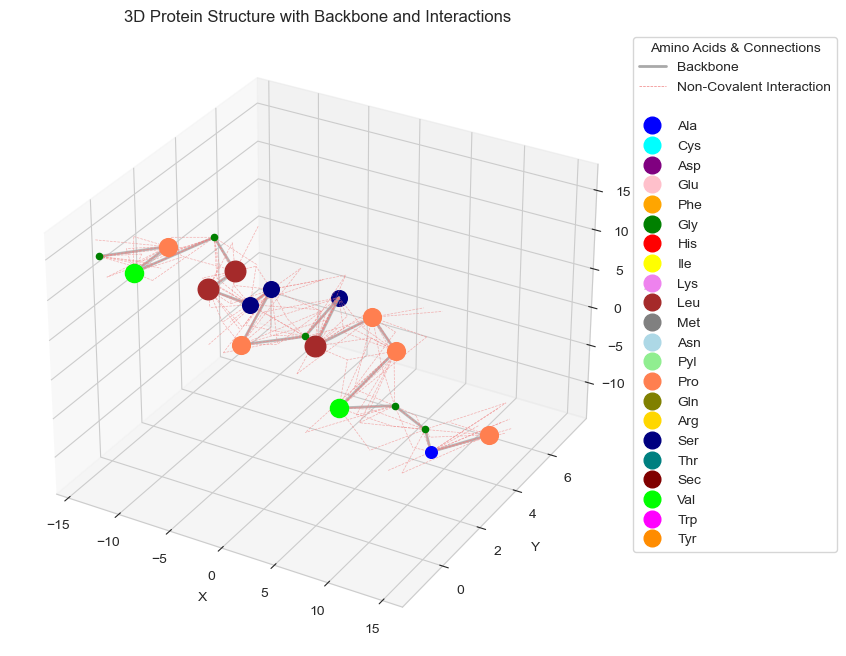

In [28]:
  # Import for creating dummy lines in legend

# Backbone and interaction extraction
backbone_connections = []
non_covalent_interactions = []

for model in structure:
    for chain in model:
        residues = list(chain)
        for i in range(len(residues) - 1):
            res1 = residues[i]
            res2 = residues[i + 1]
            if 'CA' in res1 and 'CA' in res2:
                ca1 = res1['CA'].get_coord()
                ca2 = res2['CA'].get_coord()
                if np.linalg.norm(ca1 - ca2) < 4.0:  # Peptide bond threshold
                    backbone_connections.append((ca1, ca2))

# Non-covalent interaction search
atom_list = [atom for atom in structure.get_atoms()]
neighbor_search = NeighborSearch(atom_list)

for res in structure.get_residues():
    if 'CA' in res:
        center = res['CA'].get_coord()
        neighbors = neighbor_search.search(center, 5.0)  # 5 Å radius
        for neighbor in neighbors:
            if neighbor.get_parent() != res and neighbor.element != 'H':
                non_covalent_interactions.append((center, neighbor.get_coord()))

# Plotting 3D structure with backbone and interactions
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each C-alpha with color and size, but without setting label here
for i, row in c_alpha_df.iterrows():
    x, y, z = row['X'], row['Y'], row['Z']
    aa = row['AA']
    mass = (row['Mass'] - c_alpha_df['Mass'].min()) / (c_alpha_df['Mass'].max() - c_alpha_df['Mass'].min()) * 200 + 20
    ax.scatter(x, y, z, s=mass, color=color_map.get(aa, 'black'))

# Plot backbone connections (darker, thicker lines)
for start, end in backbone_connections:
    ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], 
            color="darkgrey", linewidth=2, alpha=0.8)

# Plot non-covalent interactions (lighter, thinner lines)
for start, end in non_covalent_interactions:
    ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], 
            color="lightcoral", linestyle="--", linewidth=0.5, alpha=0.6)

# Separate legend for amino acids with full names using dummy points
for aa, color in color_map.items():
    aa_full_name = aa_name_map.get(aa, 'Unknown')
    ax.scatter([], [], [], color=color, label=aa_full_name)  # Dummy point for legend

# Create dummy lines for backbone and non-covalent interactions in the legend
backbone_line = mlines.Line2D([], [], color="darkgrey", linewidth=2, label="Backbone")
interaction_line = mlines.Line2D([], [], color="lightcoral", linestyle="--", linewidth=0.5, label="Non-Covalent Interaction")
white_space= mlines.Line2D([], [], color="white", linestyle="--", linewidth=0.5, label=" ")

# Add dummy lines to the legend
plt.legend(handles=[backbone_line, interaction_line, white_space] + [mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=10, label=aa_name_map[aa]) for aa, color in color_map.items()],
           title="Amino Acids & Connections", loc="upper left", bbox_to_anchor=(1, 1), markerscale=1.2)

# Customize plot appearance
ax.set_title("3D Protein Structure with Backbone and Interactions")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()



# Preparing the protein for an autoencoder

From the previous discussion we will try to add into the autoencoder information about the 3D coordinates of the alpha carboins (central in the aa structure), the aminoacid it refers to, encoded through its moelcular weight, sio that we also have the dimension information on the aminoacid. Additionally we add the neighborhood information so that we also have information on the non-covalent interactions fundamental for the properties.  
This all will go into the same matrix with 7 columns: X, Y, Z, MW of the atom, Avg_Neighbor_Dist, Max_Neighbor_Dist, Neighbor_Count

In [78]:
aa_info_dict = aa_info.set_index('Short').to_dict(orient='index')

# Step 1: Extract 3D coordinates and amino acid information from c_alpha_df --> the one we calculated before
coords = c_alpha_df[['X', 'Y', 'Z']].values
aa_letters = c_alpha_df['AA']

# Step 2: Use dictionary-based encoding
# Retrieve properties for each amino acid
encoded_features = []
for aa in aa_letters:
    if aa in aa_info_dict:
        avg_mass = aa_info_dict[aa]['Avg. mass (Da)']
        # Include additional properties if available --> we could add in the initial aa info for more props (i.e. polarity, hidrophobicity)
        encoded_features.append([avg_mass])
    else:
        encoded_features.append([0])  # Adjust based on features you have

# Convert encoded_features to numpy array
encoded_features = np.array(encoded_features)

# Step 3: Compute neighborhood information
# Define the radius for "neighborhood" in Å
neighborhood_radius = 5.0

# Initialize NeighborSearch
atom_list = [atom for atom in structure.get_atoms() if atom.name == 'CA']  # Use only C-alpha atoms
neighbor_search = NeighborSearch(atom_list)

# Calculate neighborhood information for each C-alpha atom
neighborhood_info = []
for res in structure.get_residues():
    if 'CA' in res:
        center = res['CA'].get_coord()
        # Find neighbors within the specified radius
        neighbors = neighbor_search.search(center, neighborhood_radius)
        # Exclude the residue itself and get neighbor distances
        distances = [np.linalg.norm(center - neighbor.get_coord()) for neighbor in neighbors if neighbor != res['CA']]
        
        # Neighborhood features
        avg_distance = np.mean(distances) if distances else 0  # Average distance to neighbors
        max_distance = np.max(distances) if distances else 0   # Max distance to neighbors
        count_neighbors = len(distances)                      # Count of neighbors within radius

        neighborhood_info.append([avg_distance, max_distance, count_neighbors])

# Step 4: Combine all features into a matrix for autoencoder input
autoencoder_input = np.hstack([
    coords,                 # 3D coordinates (X, Y, Z)
    encoded_features,       # Encoded amino acid properties from dictionary
    np.array(neighborhood_info)  # Neighborhood information
])

# Convert to DataFrame for easy viewing (optional)
columns = ['X', 'Y', 'Z', 'Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist', 'Neighbor_Count']
autoencoder_df = pd.DataFrame(autoencoder_input, columns=columns)


In [79]:
autoencoder_df

,X,Y,Z,Avg_Mass,Avg_Neighbor_Dist,Max_Neighbor_Dist,Neighbor_Count
0,23.388000,-19.139,-9.239000,149.20784,3.848671,3.848671,1.0
1,24.634001,-16.649,-6.582000,146.18934,3.834370,3.848671,2.0
2,23.024000,-14.147,-4.186000,89.09404,3.768501,3.820068,2.0
3,19.518999,-14.167,-2.949000,165.19184,3.767896,3.818858,2.0
4,20.761999,-13.862,0.649000,119.12034,3.831295,3.843732,2.0
...,...,...,...,...,...,...,...
205,-0.389000,-7.560,8.314000,117.14784,4.116339,4.713722,3.0
206,-1.093000,-4.358,10.287000,132.11904,3.878291,3.996533,3.0
207,-0.387000,-3.627,13.961000,181.19124,4.169213,4.836728,3.0
208,-2.372000,-0.894,15.827000,181.19124,4.153348,4.741887,4.0


In [80]:
print(autoencoder_input.shape)

(210, 7)


# Application on more proteins

In [84]:
# Set the path to the protein folder and random seed for reproducibility
protein_folder = '/Users/alexchilton/Downloads/archive/train'
random.seed(42)

# Step 1: Get a list of PDB files and select 15 randomly
pdb_files = glob.glob(os.path.join(protein_folder, '*.pdb'))
selected_files = random.sample(pdb_files, 15)

# List to store each protein's matrix for the autoencoder
protein_matrices = []

# Function to process each PDB file
# Process each selected PDB file
for file_path in selected_files:
    matrix = protein_parser.process_protein(file_path)
    if matrix is not None:
        protein_matrices.append(matrix)

# Check the shape of each matrix (optional)
for i, matrix in enumerate(protein_matrices):
    print(f"Protein {i+1} matrix shape: {matrix.shape}")

# Now `protein_matrices` contains 15 matrices, each for a different protein,
# with each row representing a residue and columns representing coordinates, mass, and neighborhood info.


Residue Met not in amino acid info dictionary.
Residue Lys not in amino acid info dictionary.
Residue Ala not in amino acid info dictionary.
Residue Phe not in amino acid info dictionary.
Residue Thr not in amino acid info dictionary.
Residue Lys not in amino acid info dictionary.
Residue Leu not in amino acid info dictionary.
Residue Ala not in amino acid info dictionary.
Residue Leu not in amino acid info dictionary.
Residue Phe not in amino acid info dictionary.
Residue Val not in amino acid info dictionary.
Residue Gly not in amino acid info dictionary.
Residue Leu not in amino acid info dictionary.
Residue Val not in amino acid info dictionary.
Residue Ser not in amino acid info dictionary.
Residue Gly not in amino acid info dictionary.
Residue Ala not in amino acid info dictionary.
Residue Thr not in amino acid info dictionary.
Residue Leu not in amino acid info dictionary.
Residue Ala not in amino acid info dictionary.
Residue Asn not in amino acid info dictionary.
Residue Ala n

KeyboardInterrupt: 

## Heatmap on the different proteins

In [82]:
for idx, protein_matrix in enumerate(protein_matrices):
    # Check if the matrix has at least 3 columns (X, Y, Z)
    if protein_matrix.shape[1] < 3:
        print(f"Protein {idx+1} matrix does not have the required coordinates.")
        continue
    
    # Extract C-alpha coordinates
    coordinates = protein_matrix[:, :3]  # Assuming the first 3 columns are X, Y, Z
    num_residues = len(coordinates)

    # Calculate pairwise distances
    distance_matrix = np.zeros((num_residues, num_residues))
    for i in range(num_residues):
        for j in range(i, num_residues):
            dist = np.linalg.norm(coordinates[i] - coordinates[j])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist  # Symmetric matrix

    # Plotting the heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(distance_matrix, cmap="viridis", square=True)
    plt.title(f"Protein {idx+1} C-alpha Pairwise Distance Heatmap")
    plt.xlabel("Residue Index")
    plt.ylabel("Residue Index")
    plt.show()
